# Apple Disease Detection and Classification Using CNN   
# BY EMMANUEL TOSIN SALAMI s2501163
This code is used for detection and classification of diseases in apple crop

In [1]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as kutils
import sklearn.ensemble
import sklearn.metrics
import skimage.feature
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
VALIDATION_COUNT = 30

In [3]:
print(os.getcwd())

/home/jovyan


In [6]:
ROOT_DIR = "APPLE"

In [7]:
IMAGES_DIR = os.path.join("APPLE/dataset/images")

CLASS_NAMES = sorted(os.listdir(IMAGES_DIR))
CLASSES_COUNT = len(CLASS_NAMES)# Define the number of classes
HEIGHT, WIDTH, DEPTH = 256, 256, 3#should change back to 256
print (CLASS_NAMES)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


# The data is splitted into training, validation and testing sets

In [8]:
# Create empty lists for training, validation, and testing data
x_train, y_train, x_val, y_val, x_test, y_test = [], [], [], [], [], []

for label, class_name in enumerate(CLASS_NAMES):  # Loop over all classes
    class_dir = os.path.join(IMAGES_DIR, class_name)
    filenames = os.listdir(class_dir)
    np.random.shuffle(filenames)

    images, labels = [], []
    for filename in filenames:  # Loop over all images of the class
        image_path = os.path.join(class_dir, filename)
        image = cv2.imread(image_path).astype(np.float32)[:, :, ::-1]  # Read image
        image /= 255  # Rescale brightness to [0; 1]

        # if Some images in the dataset have slightly different sizes, resize them
        if image.shape[0] != HEIGHT or image.shape[1] != WIDTH:
            image = cv2.resize(image, (HEIGHT, WIDTH))

        images.append(image)
        # Use one-hot encoding for labels
        label_one_hot = [0] * CLASSES_COUNT
        label_one_hot[label] = 1
        labels.append(label_one_hot)

    # Split data for this class into training, validation, and testing (70%, 15%, 15%)
    images_train, images_temp, labels_train, labels_temp = train_test_split(
        images, labels, test_size=0.3, random_state=123)
    images_val, images_test, labels_val, labels_test = train_test_split(
        images_temp, labels_temp, test_size=0.5, random_state=123)

    x_train.extend(images_train)
    y_train.extend(labels_train)
    x_val.extend(images_val)
    y_val.extend(labels_val)
    x_test.extend(images_test)
    y_test.extend(labels_test)

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Print dimensions
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (2157, 256, 256, 3)
y_train shape: (2157, 4)
x_val shape: (462, 256, 256, 3)
y_val shape: (462, 4)
x_test shape: (465, 256, 256, 3)
y_test shape: (465, 4)


# Defining data augmentation parameters

In [9]:
# Define data augmentation parameters
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the width of images by up to 20% of the image size
    height_shift_range=0.2,  # Randomly shift the height of images by up to 20% of the image size
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2  # Randomly zoom into images by up to 20%
)

# Create a data generator for training data
datagen.fit(x_train)


In [11]:
from tensorflow.keras.regularizers import l2
def get_regularized_model(input_shape=(HEIGHT, WIDTH, DEPTH), classes_count=CLASSES_COUNT):
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=3, activation="relu", input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(32, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes_count, activation="softmax"))
    return model

model = get_regularized_model((HEIGHT, WIDTH, DEPTH), CLASSES_COUNT)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 flatten (Flatten)           (None, 123008)           

In [12]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available")
    print("Available GPU devices:", gpus)
else:
    print("No GPU available, training on CPU")

GPU is available
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.SGD(learning_rate=1e-2),
    metrics=["accuracy"]
)

# Running epochs on sequential model

In [14]:
EPOCHS = 150
BATCH_SIZE = 32

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/150
68/68 [==============================] - 8s 45ms/step - loss: 3.8828 - accuracy: 0.6092 - val_loss: 3.5973 - val_accuracy: 0.7165
Epoch 2/150
68/68 [==============================] - 2s 35ms/step - loss: 3.6492 - accuracy: 0.6875 - val_loss: 3.8193 - val_accuracy: 0.4935
Epoch 3/150
68/68 [==============================] - 2s 35ms/step - loss: 3.4914 - accuracy: 0.7195 - val_loss: 3.2936 - val_accuracy: 0.7987
Epoch 4/150
68/68 [==============================] - 2s 35ms/step - loss: 3.3414 - accuracy: 0.7473 - val_loss: 3.1800 - val_accuracy: 0.7944
Epoch 5/150
68/68 [==============================] - 2s 36ms/step - loss: 3.2435 - accuracy: 0.7594 - val_loss: 3.1418 - val_accuracy: 0.7597
Epoch 6/150
68/68 [==============================] - 2s 35ms/step - loss: 3.1526 - accuracy: 0.7747 - val_loss: 3.2849 - val_accuracy: 0.7013
Epoch 7/150
68/68 [==============================] - 2s 34ms/step - loss: 3.0349 - accuracy: 0.7951 - val_loss: 3.0295 - val_accuracy: 0.7814
Epoch 

# Plotting model training history

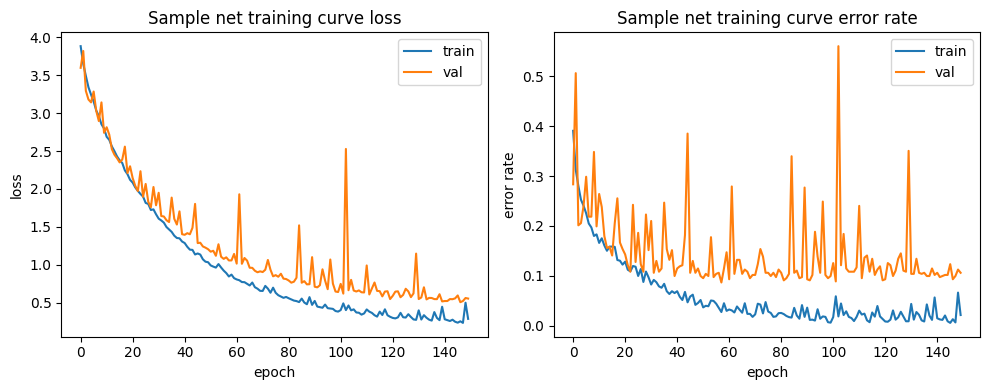

In [15]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

# Testing accuracy of the sample network

In [16]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"\nTesting accuracy of the sample network: {100 * accuracy:.2f}%")

15/15 [==============================] - 0s 16ms/step - loss: 0.5556 - accuracy: 0.8939

Testing accuracy of the sample network: 89.39%


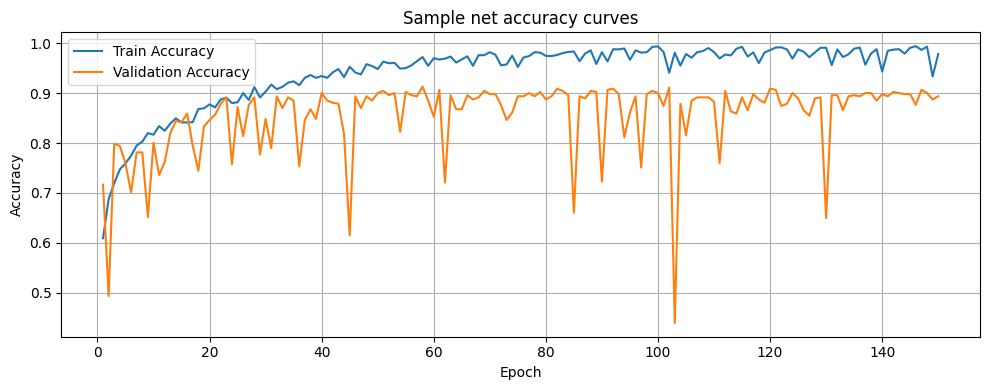

In [17]:
# Define training accuracy, validation accuracy, and testing accuracy 
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]


# Create a list of epochs
epochs = range(1, len(train_accuracy) + 1)

# Create a plot for training, validation, and testing accuracy
plt.figure(figsize=(10, 4))

plt.title("Sample net accuracy curves")
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")


plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# VGG16 PRETRAINED MODEL

In [18]:
VGG16_PATH = os.path.join("APPLE/pretrained/pretrained_VGG16.hdf5")
model = models.load_model(VGG16_PATH)
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.vgg16 import VGG16

# Get the VGG16 model so we can do transfer learning
base_vgg16 = VGG16(weights='imagenet', include_top=False,
                   input_shape=(HEIGHT, WIDTH, DEPTH))

# Add a global spatial average pooling layer
out = base_vgg16.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(CLASSES_COUNT, activation='softmax')(out)
model = Model(inputs=base_vgg16.input, outputs=predictions)

for layer in base_vgg16.layers:
    layer.trainable = True

# Compile the model with the appropriate optimizer and loss function
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

# RUNNING EPOCHS ON PRETRAINED VGG16 MODEL

In [19]:
EPOCHS = 150
BATCH_SIZE = 32

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/150
68/68 [==============================] - 26s 314ms/step - loss: 1.3574 - accuracy: 0.4873 - val_loss: 1.2195 - val_accuracy: 0.5065
Epoch 2/150
68/68 [==============================] - 19s 274ms/step - loss: 1.2223 - accuracy: 0.5053 - val_loss: 1.2122 - val_accuracy: 0.5065
Epoch 3/150
68/68 [==============================] - 19s 283ms/step - loss: 1.0986 - accuracy: 0.5545 - val_loss: 0.8272 - val_accuracy: 0.7121
Epoch 4/150
68/68 [==============================] - 20s 293ms/step - loss: 0.6754 - accuracy: 0.7492 - val_loss: 0.4430 - val_accuracy: 0.8312
Epoch 5/150
68/68 [==============================] - 20s 295ms/step - loss: 0.3953 - accuracy: 0.8516 - val_loss: 0.1879 - val_accuracy: 0.9372
Epoch 6/150
68/68 [==============================] - 20s 293ms/step - loss: 0.2814 - accuracy: 0.9026 - val_loss: 0.2049 - val_accuracy: 0.9156
Epoch 7/150
68/68 [==============================] - 20s 292ms/step - loss: 0.1648 - accuracy: 0.9407 - val_loss: 0.1510 - val_accuracy:

#  Validation accuracy

In [20]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"\n validation accuracy: {100 * accuracy:.2f}%")

15/15 [==============================] - 1s 88ms/step - loss: 0.1027 - accuracy: 0.9935

 validation accuracy: 99.35%


# Testing accurcy

In [21]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"\nTesting accuracy of the model: {100 * accuracy:.2f}%")


15/15 [==============================] - 2s 146ms/step - loss: 0.1285 - accuracy: 0.9871

Testing accuracy of the model: 98.71%


# Plotting model training history for VGG16 model

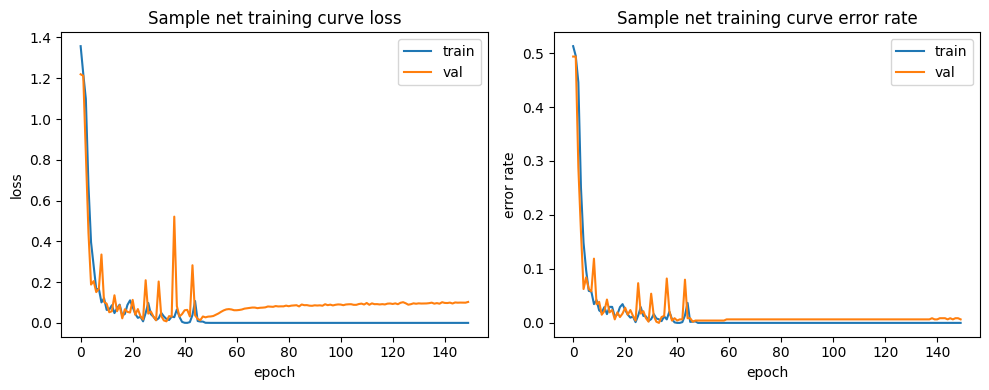

In [27]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

# Plotting net sample accuracy curve for VGG16

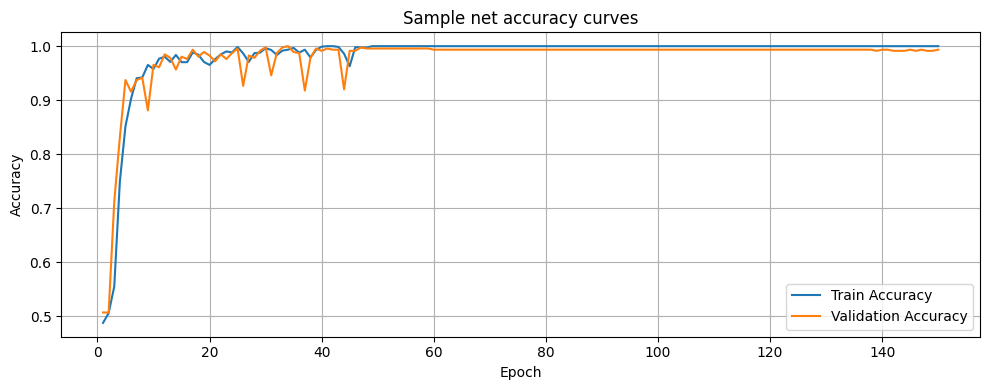

In [23]:
# Define training accuracy, validation accuracy, and testing accuracy (change these to your actual values)
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]


# Create a list of epochs
epochs = range(1, len(train_accuracy) + 1)

# Create a plot for training, validation, and testing accuracy
plt.figure(figsize=(10, 4))

plt.title("Sample net accuracy curves")
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")


plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Confusion metrix for Four class 

15/15 [==============================] - 1s 85ms/step


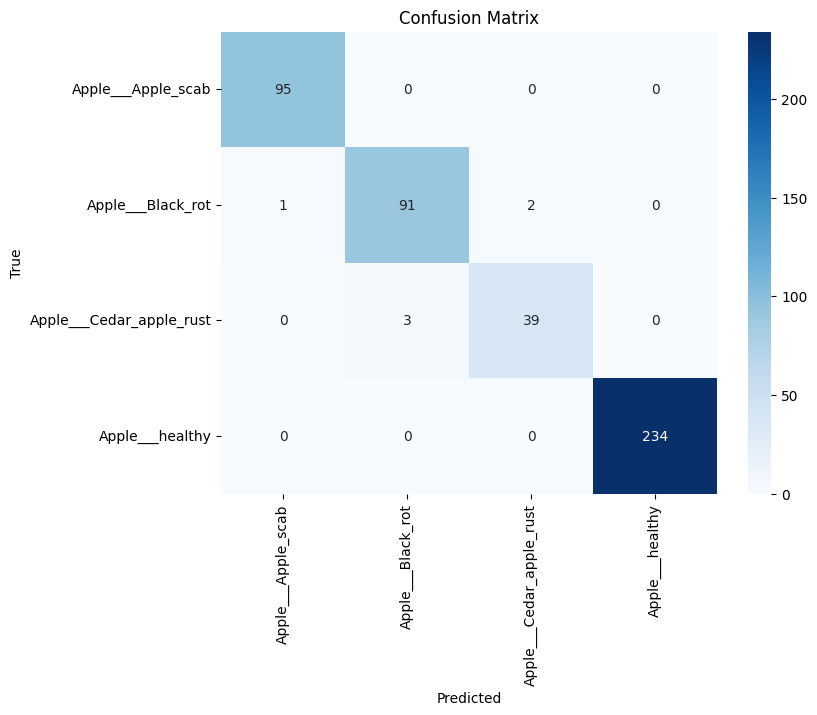

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels from the model
predicted_labels = model.predict(x_test)

# Convert one-hot encoded labels to class indices
true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Define your class labels using the actual class names
class_labels = CLASS_NAMES  # Assuming CLASS_NAMES is a list of your class names

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# PREDICTION

15/15 [==============================] - 1s 84ms/step


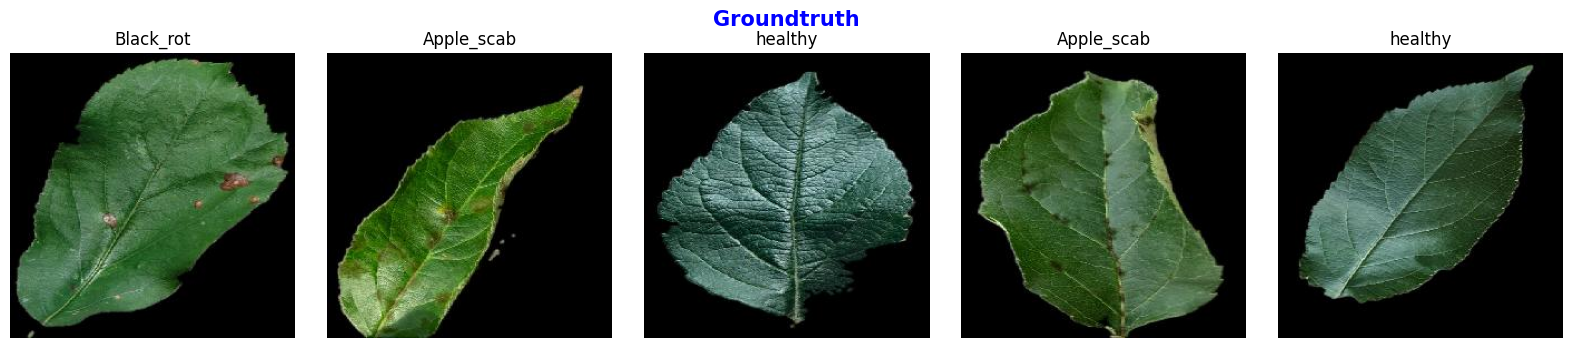

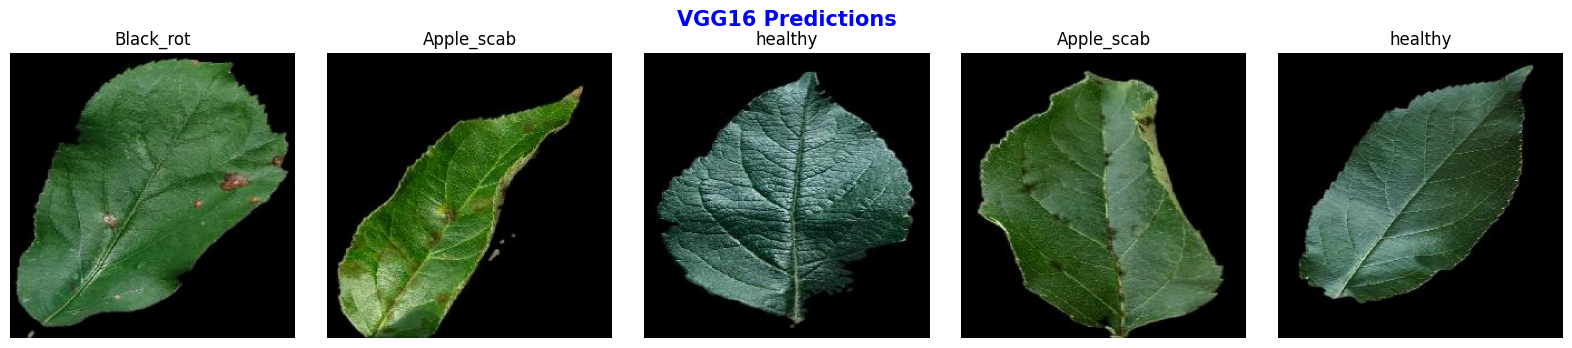

In [25]:
# Define your constants
N_SAMPLES = 5

y_pred = model.predict(x_val)
y_predicted_integer = np.argmax(y_pred, axis=1)


# Convert predicted probabilities to class indices


sample_indices = np.random.randint(x_val.shape[0], size=N_SAMPLES)


# Sample random indices for ground truth
sample_indices_ground_truth = np.random.randint(x_val.shape[0], size=N_SAMPLES)

# Sample random indices for InceptionV3 predictions
sample_indices_inceptionv3 = np.random.randint(x_val.shape[0], size=N_SAMPLES)



# Select images and corresponding labels
sample_images = x_val[sample_indices]

# Convert one-hot encoded labels to class indices
sample_true_labels = [np.argmax(label) for label in y_val[sample_indices]]
sample_predicted_labels = y_predicted_integer[sample_indices]

#y_predicted_integer = np.argmax(y_pred, axis=1)

# Create a list of class names corresponding to the labels
true_classes = [CLASS_NAMES[label].split('___')[1] for label in sample_true_labels]
predicted_classes = [CLASS_NAMES[label].split('___')[1] for label in sample_predicted_labels]

# Plot groundtruth images and labels
fig, axs = plt.subplots(1, N_SAMPLES, figsize=(16, 3.5))
plt.suptitle("Groundtruth",fontsize=15, fontweight='bold', color='blue')
for i in range(N_SAMPLES):
    axs[i].imshow(sample_images[i])
    axs[i].set_title(true_classes[i])
    axs[i].axis("off")
plt.tight_layout()
plt.show()

# Plot InceptionV3 predictions
fig, axs = plt.subplots(1, N_SAMPLES, figsize=(16, 3.5))
plt.suptitle("VGG16 Predictions",fontsize=15, fontweight='bold', color='blue')
for i in range(N_SAMPLES):
    axs[i].imshow(sample_images[i])
    axs[i].set_title(predicted_classes[i])
    axs[i].axis("off")
plt.tight_layout()
plt.show()